# Nonnegative Matrix Factorization In The Movielens Dataset

This example continues illustrating using `pandas`-munging capabilities in estimators building features that draw from several rows, this time using *NMF* ([nonnegative matrix factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)). We will use a single table from the [Movielens dataset](https://grouplens.org/datasets/movielens/) (F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS)).

## Loading The Data

In this example too, we'll only use the dataset table describing the ratings themselves. I.e., each row is an instance of a single rating given by a specific user to a specific movie.

In [1]:
import os

from sklearn import base
import pandas as pd
import scipy as sp
import seaborn as sns
sns.set_style('whitegrid')
sns.despine()

import ibex
from ibex.sklearn import model_selection as pd_model_selection
from ibex.sklearn import decomposition as pd_decomposition
from ibex.sklearn import decomposition as pd_decomposition
from ibex.sklearn import ensemble as pd_ensemble

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ratings = pd.read_csv(
    'movielens_data/ml-100k/u.data', 
    sep='\t', 
    header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'])
features = ['user_id', 'item_id']
ratings[features + ['rating']].head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


## Munging NMF With Pandas

In [Simple Row-Aggregating Features In The Movielens Dataset](https://github.com/atavory/ibex/blob/master/examples/movielens_simple_row_aggregating_features.ipynb) we looked at direct attributes obtainable from the rankings: the average user and item ranking. Here we'll use Pandas to bring the dataset to a form where we can find [latent factors](https://en.wikipedia.org/wiki/Latent_variable) through NMF.

First we pivot the table so that we have a ``UI`` matrix of the users as rows, the items as columns, and the ratings as the values:

In [4]:
UI = pd.pivot_table(ratings, values='rating', index='user_id', columns ='item_id')
UI

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4,NaN,NaN,NaN,NaN,NaN,2,4,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,5,NaN,NaN,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,5,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now use NMF for decomposition, and then find the user latent factors in ``U`` and item latent factors in ``I``:

In [5]:
d = pd_decomposition.NMF(n_components=20)
U = d.fit_transform(UI.fillna(0))
I = d.components_

Note that the Ibex version of ``NMF`` sets the indexes and columns of the ``U`` and ``I`` appropriately.

In [6]:
U.head()

,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,comp_11,comp_12,comp_13,comp_14,comp_15,comp_16,comp_17,comp_18,comp_19
user_id,,,,,,,,,,,,,,,,,,,,
1,0.485576,0.000000,0.315890,0.000000,0.630578,0.000000,1.601014,0,0.455935,0.217558,0.385754,0.489440,0.645079,0.547663,0.000000,0.140221,0.194926,0.010919,0.092003,0.681740
2,0.000000,0.152857,0.000000,0.031027,0.000000,0.038423,0.000000,0,0.000000,0.000000,0.739028,0.022548,0.000000,0.000000,0.522053,0.000000,0.414483,0.000000,0.646464,0.140031
3,0.022436,0.000000,0.011997,0.546571,0.204735,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.033809,0.000000,0.346670,0.000000,0.026469,0.000000,0.223145,0.000000
4,0.000000,0.000000,0.000000,0.504944,0.000000,0.022348,0.000000,0,0.000000,0.022946,0.000000,0.000000,0.133956,0.000000,0.000000,0.030882,0.190410,0.000000,0.207494,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.465002,0,0.221054,0.417572,0.000000,0.821748,0.000000,0.260957,0.000000,0.000000,0.184009,0.455583,0.000000,0.000000


In [7]:
I.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
comp_0,0.365118,0.000000,0.000000,0.637095,0.222285,0.000000,0.000000,0.775547,2.056821,0.000000,...,0.015426,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029726,0.001597
comp_1,1.610726,0.000000,0.262760,0.000000,0.260195,0.000000,1.148924,0.000000,0.428664,0.008343,...,0.000000,0,0.008265,0.005510,0.006730,0.000000,0.000000,0.000000,0.000000,0.000000
comp_2,0.000000,0.000000,0.518993,1.393652,0.006631,0.037708,0.448347,0.208778,0.676369,0.033487,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038217
comp_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147421,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.004228,0.012685,0.008457,0.000000,0.000000
comp_4,0.000000,0.175077,0.229653,0.279314,0.000000,0.324383,0.226987,1.058556,0.143271,0.298239,...,0.000000,0,0.019432,0.012955,0.028124,0.000000,0.000000,0.000000,0.000000,0.000000


Pandas makes it easy to merge the user and item latent factors to the users and items, respectively.

In [8]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [10]:
rating_comps = pd.merge(
    ratings,
    U,
    left_on='user_id',
    right_index=True,
    how='left')
rating_comps = pd.merge(
    rating_comps,
    I.T,
    left_on='item_id',
    right_index=True,
    how='left')
rating_comps.head()

,user_id,item_id,rating,timestamp,comp_0_x,comp_1_x,comp_2_x,comp_3_x,comp_4_x,comp_5_x,...,comp_10_y,comp_11_y,comp_12_y,comp_13_y,comp_14_y,comp_15_y,comp_16_y,comp_17_y,comp_18_y,comp_19_y
0,196,242,3,881250949,0.000000,0.057046,0.000000,0.000000,0.076994,0.058962,...,0.175382,0,0.0000,0.017391,0.000000,0,0.000000,0.000000,2.352112,0.765164
1,186,302,3,891717742,0.186303,0.540434,0.000000,0.375188,0.076878,0.000000,...,0.189148,0,0.3162,0.000000,2.475617,0,0.000000,0.000000,4.846549,0.000000
2,22,377,1,878887116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.0000,0.054262,0.000000,0,0.009775,0.085702,0.000000,0.000000
3,244,51,2,880606923,0.888563,0.205312,0.502265,0.000000,0.000000,1.027671,...,0.000000,0,0.0000,0.258619,0.000000,0,0.000000,0.000000,0.000000,0.000000
4,166,346,1,886397596,0.000000,0.000000,0.000000,0.563448,0.000000,0.000000,...,0.000000,0,0.0000,0.095130,2.306514,0,0.000000,0.000000,0.249914,0.000000


Let's merge to the results also the number of occurrences to of the users and items, respectively.

In [12]:
rating_comps = pd.merge(
    rating_comps,
    ratings.groupby(ratings.user_id).size().to_frame().rename(columns={0: 'user_id_count'}),
    left_on='user_id',
    right_index=True,
    how='left')
rating_comps = pd.merge(
    rating_comps,
    ratings.groupby(ratings.item_id).size().to_frame().rename(columns={0: 'item_id_count'}),
    left_on='user_id',
    right_index=True,
    how='left')
prd_features = [c for c in rating_comps if 'comp_' in c] + ['user_id_count', 'item_id_count']
rating_comps.head()

,user_id,item_id,rating,timestamp,comp_0_x,comp_1_x,comp_2_x,comp_3_x,comp_4_x,comp_5_x,...,comp_12_y,comp_13_y,comp_14_y,comp_15_y,comp_16_y,comp_17_y,comp_18_y,comp_19_y,user_id_count,item_id_count
0,196,242,3,881250949,0.000000,0.057046,0.000000,0.000000,0.076994,0.058962,...,0.0000,0.017391,0.000000,0,0.000000,0.000000,2.352112,0.765164,39,251
1,186,302,3,891717742,0.186303,0.540434,0.000000,0.375188,0.076878,0.000000,...,0.3162,0.000000,2.475617,0,0.000000,0.000000,4.846549,0.000000,92,251
2,22,377,1,878887116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.054262,0.000000,0,0.009775,0.085702,0.000000,0.000000,128,297
3,244,51,2,880606923,0.888563,0.205312,0.502265,0.000000,0.000000,1.027671,...,0.0000,0.258619,0.000000,0,0.000000,0.000000,0.000000,0.000000,238,48
4,166,346,1,886397596,0.000000,0.000000,0.000000,0.563448,0.000000,0.000000,...,0.0000,0.095130,2.306514,0,0.000000,0.000000,0.249914,0.000000,20,58


We now have a dataframe of latent variables. Let's build a random forest regressor, and use it on this dataframe.

In [13]:
prd = pd_ensemble.RandomForestRegressor().fit(rating_comps[prd_features], ratings.rating)
prd.score(rating_comps[prd_features], ratings.rating)

0.87112316121555944

Finally, let's check the feature importances.

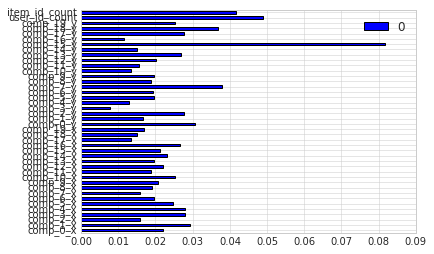

In [73]:
prd.feature_importances_.to_frame().plot(kind='barh');

## Building A Pandas-Munging Estimator

We'll now build a Scikit-Learn / Pandas step doing the above.

In [83]:
class RatingsFactorizer(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        X = pd.concat([X[['user_id', 'item_id']], y])
        X.columns = ['user_id', 'item_id', 'rating']
        self._user_id_count = X.groupby(X.user_id).size().to_frame().rename(columns={0: 'user_id_count'})
        self._item_id_count = X.groupby(X.item_id).size().to_frame().rename(columns={0: 'item_id_count'})
        UI = pd.pivot_table(ratings, values='rating', index='user_id', columns ='item_id')
        d = pd_decomposition.NMF(n_components=10)
        self._U = d.fit_transform(UI.fillna(0))
        self._I = d.components_
        return self

    def transform(self, X):
        rating_comps = pd.merge(
            X[['user_id', 'item_id']],
            self._U,
            left_on='user_id',
            right_index=True,
            how='left')
        rating_comps = pd.merge(
            rating_comps,
            self._I.T,
            left_on='item_id',
            right_index=True,
            how='left')
        rating_comps = pd.merge(
            rating_comps,
            self._user_id_count,
            left_on='user_id',
            right_index=True,
            how='left')
        rating_comps = pd.merge(
            rating_comps,
            self._item_id_count,
            left_on='user_id',
            right_index=True,
            how='left')
        prd_features = [c for c in rating_comps if 'comp_' in c] + ['user_id_count', 'item_id_count']
        return rating_comps[prd_features].fillna(0)

We can now use cross validation to assess this scheme.

/usr/lib/python3/dist-packages/pandas/core/index.py:6154: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)
/usr/lib/python3/dist-packages/pandas/core/index.py:6154: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)
/usr/lib/python3/dist-packages/pandas/core/index.py:6154: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)
/usr/lib/python3/dist-packages/pandas/core/index.py:6154: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)
/usr/lib/python3/dist-packages/pandas/core/index.py:6154: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)
/usr/lib/python3/dist-packages/pandas/core/index.py:6154: Ru

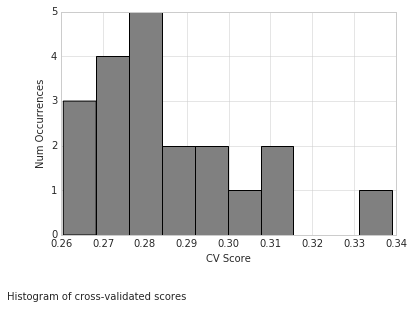

In [84]:
prd = RatingsFactorizer() | pd_ensemble.RandomForestRegressor()
hist(
    pd_model_selection.cross_val_score(
        prd, 
        ratings[features], 
        ratings.rating,
        cv=20,
        n_jobs=-1),
    color='grey');
xlabel('CV Score')
ylabel('Num Occurrences')
figtext(
    0, 
    -0.1, 
    'Histogram of cross-validated scores');